<a href="https://colab.research.google.com/github/trongtn2110/CS114.L21/blob/master/ProjectCS114/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Aug 17 15:15:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Step 1. Mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import gdown
%cd /content/gdrive/My\ Drive
!mkdir Data_CS114
%cd /content/gdrive/My\ Drive/Data_CS114

/content/gdrive/My Drive
/content/gdrive/My Drive/Data_CS114


In [4]:
!gdown --id 1FRg4q4qTi2ImfpMxE5EnLeDRCHNxo13C #Testimg.zip
!gdown --id 1gDtyugP41svdzTfWaWyysWC4Co3X0rIs #Testlabel.zip

Downloading...
From: https://drive.google.com/uc?id=1FRg4q4qTi2ImfpMxE5EnLeDRCHNxo13C
To: /content/gdrive/My Drive/Data_CS114/testimg.zip
1.49GB [00:12, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gDtyugP41svdzTfWaWyysWC4Co3X0rIs
To: /content/gdrive/My Drive/Data_CS114/testlabel.zip
100% 332k/332k [00:00<00:00, 10.6MB/s]


In [8]:
!mkdir Test

mkdir: cannot create directory ‘Test’: File exists


In [9]:

# !unzip trainimg.zip -d "/content/gdrive/MyDrive/Data_CS114/Train"
!unzip testimg.zip -d "/content/gdrive/MyDrive/Data_CS114/Test"
# !unzip trainlabel.zip -d "/content/gdrive/MyDrive/Data_CS114/Train"
!unzip testlabel.zip -d "/content/gdrive/MyDrive/Data_CS114/Test"

Archive:  testimg.zip
   creating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage0.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage1.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage10.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage100.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage101.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage102.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage103.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage104.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage105.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage106.jpg  
  inflating: /content/gdrive/MyDrive/Data_CS114/Test/testimg/Yoloimage107.jpg  
  inflating: /content/gdrive/MyDrive/Data

In [10]:
# import all the tools we need
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests
from google.colab.patches import cv2_imshow
import matplotlib.patches as patches

In [11]:
# path of images directory
# img_train_path = '/content/gdrive/MyDrive/Data_CS114/Train/trainimg'
img_test_path = '/content/gdrive/MyDrive/Data_CS114/Test/testimg'

# path of xml files directory
# label_train_path = '/content/gdrive/MyDrive/Data_CS114/Train/train_label'
label_test_path = '/content/gdrive/MyDrive/Data_CS114/Test/test_label'

# List of Image file name 
# img_train_list =list(sorted(os.listdir(img_train_path)))
img_test_list = list(sorted(os.listdir(img_test_path)))
# label_train_list= list(sorted(os.listdir(label_train_path)))
label_test_list= list(sorted(os.listdir(label_test_path)))

# How many image files?
# print('There are total {} images train and {} images test.'.format(len(img_train_list),len(img_test_list)))

In [13]:
# Helper function for read the data (label and bounding boxes) from xml file 
def read_label(file_name, label_dir):
    """
    Function used to get the bounding boxes and labels from the xml file
    Input:
        file_name: image file name
        xml_dir: directory of xml file
    Return:
        bbox : list of bounding boxes
        labels: list of labels
    """
    bbox = []
    labels = []
    
    label_path = os.path.join(label_dir, file_name[:-3]+'xml')
    tree = ET.parse(label_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'Correct':
            label_idx = 1
        elif label == 'No-mask':
          label_idx = 2
        elif label == 'Incorrect':
            label_idx = 3
        labels.append(label_idx)
        
    return bbox, labels

# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=3):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
    font =  cv2.FONT_HERSHEY_SIMPLEX
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 3:
          color = (255,0,255) #pink
          text = 'Incorrect'
        elif label == 2:
          color = (0,0,225) # red
          text = 'Nomask'
        elif label == 1:
          color = (0,255,0) # green
          text = 'Correct'
        cv2.putText(img,text,(box[0],box[1]), font, 1 ,color, thickness)
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [14]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, label_train_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = label_train_dir
        self.classes = [_, 'Correct','No-mask','Incorrect']
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_label(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

In [16]:

mask_dataset_test = image_dataset(img_test_list, img_test_path, label_test_path)

def collate_fn(batch):
    return tuple(zip(*batch))


mask_loader_test = DataLoader(mask_dataset_test,batch_size=10,shuffle=True,num_workers=4,collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
%cd /content/gdrive/My\ Drive/Data_CS114
!gdown --id 1UaAA1bB3xkwzqtbSK639R0xbeD5bXAeh

/content/gdrive/My Drive/Data_CS114
Downloading...
From: https://drive.google.com/uc?id=1UaAA1bB3xkwzqtbSK639R0xbeD5bXAeh
To: /content/gdrive/My Drive/Data_CS114/model_final_cs114_1.pth
166MB [00:01, 113MB/s]


In [22]:
model = get_model_instance_segmentation(4)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Data_CS114/model_final_cs114_1.pth'))
model = model.to(device)

#**PREDICT**

In [23]:
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.5):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter =  predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


431


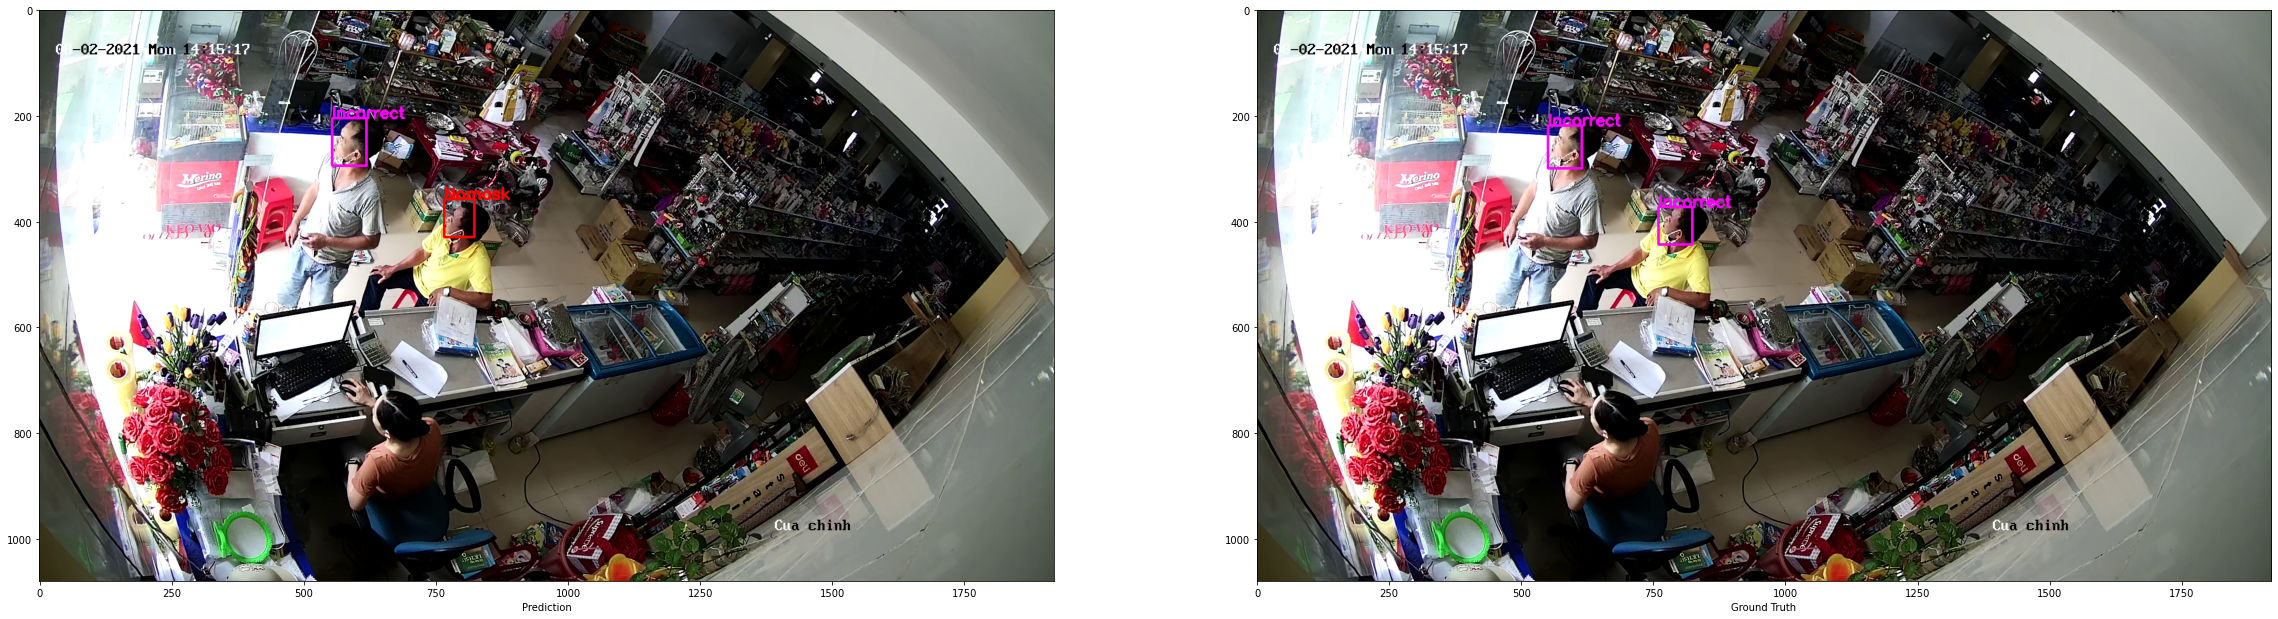

In [27]:
    idx = random.randint(1,len(img_test_list))
    # idx = 210
    test_img = Image.open(os.path.join(img_test_path,img_test_list[idx]))
    # test_img = test_img.cuda()
    # Prediction
    test_img, test_boxes, test_labels= single_img_predict(test_img)
    # print(test_boxes)
    # print(test_labels)
    # print(score[:len(test_labels)])
    test_output = draw_boxes(test_img, test_boxes,test_labels)
    # t = test_output

    # Draw the bounding box of ground truth
    bbox, labels  = read_label(img_test_list[idx], label_test_path)
    # #draw bounding boxes on the image
    gt_output = draw_boxes(test_img, bbox,labels)
    print(idx)
    # img1 = Image.fromarray((test_output * 150).astype(np.uint8))
    # img1 = img1.convert('RGB')
    # img1.save("/content/drive/MyDrive/Data_Project_CS114/Predict/imagePred{}.jpg".format(idx))
    # Display the result
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(40,80))
    ax1.imshow(test_output)
    ax1.set_xlabel('Prediction')
    ax2.imshow(gt_output)
    ax2.set_xlabel('Ground Truth')
    plt.show()